<a href="https://colab.research.google.com/github/willianncardoso/IBOVESPA/blob/RandomForestClassifier/PosFIAP_T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo Random Forest Classifier

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [53]:
# 1. Obtenção dos Dados
# Usando 'period' para pegar os dados dos últimos 2 anos
dados = pd.read_csv('https://raw.githubusercontent.com/willianncardoso/IBOVESPA/refs/heads/main/Dados%20Hist%C3%B3ricos%20-%20Ibovespa.csv')

dados.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,04.07.2025,141.264,140.928,141.564,140.597,"3,31B","0,24%"
1,03.07.2025,140.928,139.051,141.304,139.051,"6,08B","1,35%"
2,02.07.2025,139.051,139.586,140.049,138.384,"8,81B","-0,36%"
3,01.07.2025,139.549,138.855,139.695,138.855,"6,35B","0,50%"
4,30.06.2025,138.855,136.865,139.103,136.430,"7,68B","1,45%"


In [54]:
def converter_volume_simples(valor):
    # Deixa tudo maiúsculo, troca vírgula por ponto e remove espaços
    valor_str = str(valor).upper().replace(',', '.').strip()

    if 'B' in valor_str:
        return int(float(valor_str.replace('B', '')) * 1_000_000_000)
    elif 'M' in valor_str:
        return int(float(valor_str.replace('M', '')) * 1_000_000)
    else:
        # Se não tiver letra, apenas converte para número
        return int(float(valor_str))

dados['Vol.'] = dados['Vol.'].apply(converter_volume_simples)

# Convertendo a data formato
dados['Data'] = pd.to_datetime(dados['Data'], format='%d.%m.%Y')

# Inverter Data Ascending
dados.sort_values(by='Data', ascending=True, inplace=True)

# Data como índice
dados.set_index('Data', inplace=True)


In [55]:
dados['Var%'] = pd.to_numeric(dados['Var%'].str.replace('%', '').str.replace(',', '.')) / 100

dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 502 entries, 2023-06-30 to 2025-07-04
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    502 non-null    float64
 1   Abertura  502 non-null    float64
 2   Máxima    502 non-null    float64
 3   Mínima    502 non-null    float64
 4   Vol.      502 non-null    int64  
 5   Var%      502 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 27.5 KB


In [56]:
# 2. Engenharia de Atributos para Classificação

# Criando a variável-alvo (Target)
# 1 se o preço de fechamento de amanhã for MAIOR que o de hoje, 0 caso contrário
dados['Target'] = (dados['Último'].shift(-1) > dados['Último']).astype(int)

# Remover a última linha que terá um 'Target' NaN
dados.dropna(inplace=True)

In [57]:
# 3. Criação das Variáveis Preditivas (Features)

# Lags (preços dos dias anteriores)
# for i in range(1, 6):
#     dados[f'Lag_{i}'] = dados['Último'].shift(i)

# # Médias Móveis
# dados['SMA_10'] = dados['Último'].rolling(window=10).mean()
# dados['SMA_30'] = dados['Último'].rolling(window=30).mean()

# Volatilidade (desvio padrão dos retornos em uma janela)
# dados['Volatility_10'] = dados['Daily_Return'].rolling(window=10).std()

# Remover linhas com NaN gerados pelas features
dados.dropna(inplace=True)

print("\n--- Dados Finais com Features ---")
dados


--- Dados Finais com Features ---


,Último,Abertura,Máxima,Mínima,Vol.,Var%,Target
Data,,,,,,,
2023-06-30,118.087,118.388,119.447,118.087,13820000,-0.0025,1
2023-07-03,119.673,118.092,119.877,118.092,8910000,0.0134,0
2023-07-04,119.076,119.673,119.678,118.830,6560000,-0.0050,1
2023-07-05,119.549,119.072,120.200,118.688,10960000,0.0040,0
2023-07-06,117.426,119.548,119.548,117.096,11030000,-0.0178,1
...,...,...,...,...,...,...,...
2025-06-30,138.855,136.865,139.103,136.430,7680000000,0.0145,1
2025-07-01,139.549,138.855,139.695,138.855,6350000000,0.0050,0
2025-07-02,139.051,139.586,140.049,138.384,8810000000,-0.0036,1


In [58]:
print("Removendo a feature com vazamento de dados: 'Var%'")
# Use o nome exato da sua coluna de variação aqui
# O 'errors='ignore'' evita um erro caso a coluna não exista ou já tenha sido removida
dados.drop(columns=['Var%'], inplace=True, errors='ignore')

Removendo a feature com vazamento de dados: 'Var%'


In [69]:
# criação de uma feature de variação segura, que olha para o passado.
dados['Variacao_Dia_Anterior'] = dados['Último'].pct_change()

# Lembre-se que isso vai criar um NaN na primeira linha, então
# é importante rodar o dropna() depois de criar todas as features
dados.dropna(inplace=True)

dados

,Último,Abertura,Máxima,Mínima,Vol.,Target,Variacao_Dia_Anterior
Data,,,,,,,
2023-07-04,119.076,119.673,119.678,118.830,6560000,1,-0.004989
2023-07-05,119.549,119.072,120.200,118.688,10960000,0,0.003972
2023-07-06,117.426,119.548,119.548,117.096,11030000,1,-0.017758
2023-07-07,118.898,117.427,119.549,117.427,10520000,0,0.012536
2023-07-10,117.942,118.897,118.897,117.814,8100000,0,-0.008041
...,...,...,...,...,...,...,...
2025-06-30,138.855,136.865,139.103,136.430,7680000000,1,0.014532
2025-07-01,139.549,138.855,139.695,138.855,6350000000,0,0.004998
2025-07-02,139.051,139.586,140.049,138.384,8810000000,1,-0.003569


In [70]:
# 4. Preparação para o Modelo
features = [col for col in dados.columns if col not in ['Data','Target']]
X = dados[features]
y = dados['Target']

# Divisão cronológica dos dados (80% treino, 20% teste)
tamanho_treino = int(len(dados) * 0.8)
X_treino, X_teste = X[:tamanho_treino], X[tamanho_treino:]
y_treino, y_teste = y[:tamanho_treino], y[tamanho_treino:]

print(f"\nTamanho do conjunto de Treino: {len(X_treino)} amostras")
print(f"Tamanho do conjunto de Teste: {len(X_teste)} amostras")


Tamanho do conjunto de Treino: 400 amostras
Tamanho do conjunto de Teste: 100 amostras


In [71]:
print("--- Verificando as colunas em X antes do treino ---")
print(X_treino.columns.tolist())

--- Verificando as colunas em X antes do treino ---
['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Variacao_Dia_Anterior']


In [72]:
# Treinamento do Modelo
# RandomForestClassifier para problemas de classificação
modelo = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
modelo.fit(X_treino, y_treino)

RandomForestClassifier(n_jobs=-1, random_state=42)


--- Resultados da Avaliação ---
Acurácia do Modelo: 49.00%

Relatório de Classificação:
                  precision    recall  f1-score   support

Caiu/Manteve (0)       0.46      0.91      0.61        44
       Subiu (1)       0.69      0.16      0.26        56

        accuracy                           0.49       100
       macro avg       0.58      0.53      0.44       100
    weighted avg       0.59      0.49      0.41       100


Matriz de Confusão:


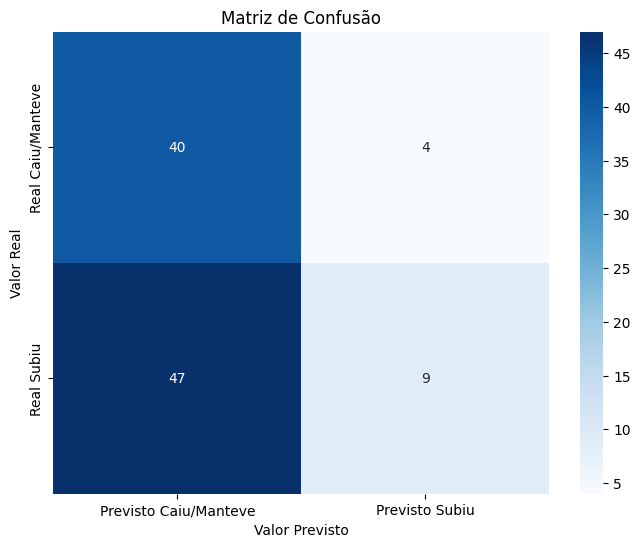

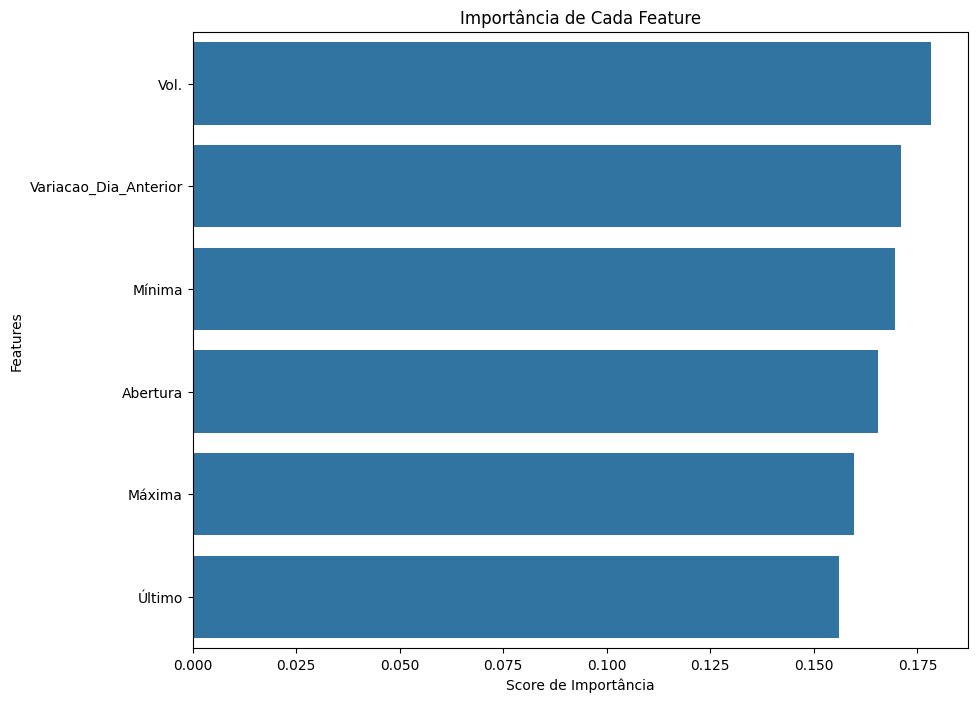

In [73]:
# Avaliação do Desempenho
previsoes = modelo.predict(X_teste)

# Calcular a acurácia
acuracia = accuracy_score(y_teste, previsoes)
print(f"\n--- Resultados da Avaliação ---")
print(f"Acurácia do Modelo: {acuracia:.2%}")

# Exibir o Relatório de Classificação
print("\nRelatório de Classificação:")
# target_names mapeia os valores 0 e 1 para rótulos mais claros
print(classification_report(y_teste, previsoes, target_names=['Caiu/Manteve (0)', 'Subiu (1)']))

# Exibir a Matriz de Confusão
print("\nMatriz de Confusão:")
cm = confusion_matrix(y_teste, previsoes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsto Caiu/Manteve', 'Previsto Subiu'],
            yticklabels=['Real Caiu/Manteve', 'Real Subiu'])
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.title('Matriz de Confusão')
plt.show()

# Importância das Features
# Ver quais features o modelo considerou mais importantes para a decisão
importancias = pd.Series(modelo.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=importancias, y=importancias.index)
plt.title('Importância de Cada Feature')
plt.xlabel('Score de Importância')
plt.ylabel('Features')
plt.show()

In [65]:
# import yfinance as yf

# # SEU DADO PRINCIPAL É O ÍNDICE IBOVESPA
# ticker_alvo = '^BVSP'

# print(f"Buscando dados para o alvo principal: Índice Ibovespa ({ticker_alvo})")
# dados_principais = yf.download(ticker_alvo, period='2y', auto_adjust=True)

# # A partir daqui, você faz a engenharia de atributos neste DataFrame
# # Ex: criar a coluna 'Target' para saber se o ÍNDICE subiu ou desceu no dia seguinte
# dados_principais['Target'] = (dados_principais['Close'].shift(-1) > dados_principais['Close']).astype(int)

# print("\n--- Dados do Ibovespa com a Coluna Alvo ---")
# print(dados_principais.head())

In [66]:
# A partir daqui inclusão de dados comuns da bovespa que podem melhorar o modelo

In [74]:
# Passo 1: Adicionar as features de contexto (SP&500, Dólar, etc.)
# =================================================================
print("\nIniciando a Etapa de Enriquecimento de Features...")

# Usaremos o seu DataFrame 'dados' já ordenado e com o índice correto
tickers_contexto = {
    'SP500': '^GSPC',      # Mercado Americano
    'DOLAR': 'USDBRL=X',   # Câmbio
    'PETROLEO': 'CL=F'     # Commodities
}

for nome, ticker in tickers_contexto.items():
    print(f"Buscando dado de contexto: {nome} ({ticker})")
    # Pega a variação diária do preço de fechamento do ativo de contexto
    # e a adiciona como uma nova coluna no seu DataFrame 'dados'
    dados[f'Var_{nome}'] = yf.download(ticker, start=dados.index.min(), end=dados.index.max())['Close'].pct_change()



/tmp/ipython-input-74-1622344442.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados[f'Var_{nome}'] = yf.download(ticker, start=dados.index.min(), end=dados.index.max())['Close'].pct_change()
[*********************100%***********************]  1 of 1 completed


Iniciando a Etapa de Enriquecimento de Features...
Buscando dado de contexto: SP500 (^GSPC)
Buscando dado de contexto: DOLAR (USDBRL=X)



/tmp/ipython-input-74-1622344442.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados[f'Var_{nome}'] = yf.download(ticker, start=dados.index.min(), end=dados.index.max())['Close'].pct_change()
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-74-1622344442.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados[f'Var_{nome}'] = yf.download(ticker, start=dados.index.min(), end=dados.index.max())['Close'].pct_change()
[*********************100%***********************]  1 of 1 completed


Buscando dado de contexto: PETROLEO (CL=F)


In [75]:
# Passo 2: Criar features de Lag para o contexto
# =================================================================
print("\nCriando features de Lag...")
features_de_contexto = ['Var_SP500', 'Var_DOLAR', 'Var_PETROLEO']
for feature in features_de_contexto:
    # Criando um lag de 1 dia para cada feature de contexto
    dados[f'{feature}_Lag_1'] = dados[feature].shift(1)


Criando features de Lag...


In [76]:
# Passo 3: Limpeza Final
# =================================================================
# Após adicionar todas as novas features, removemos as linhas com valores NaN
# que foram criadas pelos cálculos de .pct_change() e .shift()
print("\nLimpando dados e finalizando...")
dados.dropna(inplace=True)


Limpando dados e finalizando...


In [77]:
# Passo 4: Verificação Final do DataFrame Pronto para o Modelo
# =================================================================
print("\n--- SEU DATAFRAME FINAL E ENRIQUECIDO ---")
print(dados.head())
print(f"\nNúmero final de features: {len(dados.columns) - 1}") # -1 para não contar o 'Target'


--- SEU DATAFRAME FINAL E ENRIQUECIDO ---
             Último  Abertura   Máxima   Mínima      Vol.  Target  \
Data                                                                
2023-07-07  118.898   117.427  119.549  117.427  10520000       0   
2023-07-10  117.942   118.897  118.897  117.814   8100000       0   
2023-07-11  117.556   117.942  117.942  115.704  10590000       1   
2023-07-12  117.666   117.557  119.156  117.557   8940000       1   
2023-07-13  119.264   117.671  119.739  117.668   9260000       0   

            Variacao_Dia_Anterior  Var_SP500  Var_DOLAR  Var_PETROLEO  \
Data                                                                    
2023-07-07               0.012536  -0.002865   0.014751      0.028691   
2023-07-10              -0.008041   0.002405  -0.009718     -0.011779   
2023-07-11              -0.003273   0.006742   0.005605      0.025209   
2023-07-12               0.000936   0.007411  -0.009534      0.012295   
2023-07-13               0.013581  

In [78]:
dados

,Último,Abertura,Máxima,Mínima,Vol.,Target,Variacao_Dia_Anterior,Var_SP500,Var_DOLAR,Var_PETROLEO,Var_SP500_Lag_1,Var_DOLAR_Lag_1,Var_PETROLEO_Lag_1
Data,,,,,,,,,,,,,
2023-07-07,118.898,117.427,119.549,117.427,10520000,0,0.012536,-0.002865,0.014751,0.028691,-0.007923,0.001508,0.000139
2023-07-10,117.942,118.897,118.897,117.814,8100000,0,-0.008041,0.002405,-0.009718,-0.011779,-0.002865,0.014751,0.028691
2023-07-11,117.556,117.942,117.942,115.704,10590000,1,-0.003273,0.006742,0.005605,0.025209,0.002405,-0.009718,-0.011779
2023-07-12,117.666,117.557,119.156,117.557,8940000,1,0.000936,0.007411,-0.009534,0.012295,0.006742,0.005605,0.025209
2023-07-13,119.264,117.671,119.739,117.668,9260000,0,0.013581,0.008470,-0.007132,0.015049,0.007411,-0.009534,0.012295
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-27,136.866,137.113,137.209,136.469,6240000000,1,-0.001809,0.005219,-0.014538,0.004292,0.008020,0.008638,0.004929
2025-06-30,138.855,136.865,139.103,136.430,7680000000,1,0.014532,0.005164,0.000237,-0.006258,0.005219,-0.014538,0.004292
2025-07-01,139.549,138.855,139.695,138.855,6350000000,0,0.004998,-0.001119,-0.008798,0.005222,0.005164,0.000237,-0.006258


In [82]:
print("--- Verificando as colunas em X antes do treino ---")
print(X_treino.columns.tolist())

--- Verificando as colunas em X antes do treino ---
['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Variacao_Dia_Anterior', 'Var_SP500', 'Var_DOLAR', 'Var_PETROLEO', 'Var_SP500_Lag_1', 'Var_DOLAR_Lag_1', 'Var_PETROLEO_Lag_1']


In [117]:
# Preparação para o Modelo
features = [col for col in dados.columns if col not in ['Data','Target',
                                                        'Var_PETROLEO',
                                                        'Var_DOLAR_Lag_1', 'Var_PETROLEO_Lag_1']]
X = dados[features]
y = dados['Target']

# Divisão cronológica dos dados (80% treino, 20% teste)
tamanho_treino = int(len(dados) * 0.8)
X_treino, X_teste = X[:tamanho_treino], X[tamanho_treino:]
y_treino, y_teste = y[:tamanho_treino], y[tamanho_treino:]

print(f"\nTamanho do conjunto de Treino: {len(X_treino)} amostras")
print(f"Tamanho do conjunto de Teste: {len(X_teste)} amostras")


Tamanho do conjunto de Treino: 376 amostras
Tamanho do conjunto de Teste: 94 amostras


In [118]:
# Treinamento do Modelo
# RandomForestClassifier para problemas de classificação
modelo = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
modelo.fit(X_treino, y_treino)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [119]:
print("--- Verificando as colunas em X depois do treino ---")
print(X_treino.columns.tolist())

--- Verificando as colunas em X depois do treino ---
['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Variacao_Dia_Anterior', 'Var_SP500', 'Var_DOLAR', 'Var_SP500_Lag_1']



--- Resultados da Avaliação ---
Acurácia do Modelo: 60.64%

Relatório de Classificação:
                  precision    recall  f1-score   support

Caiu/Manteve (0)       0.53      0.78      0.63        40
       Subiu (1)       0.74      0.48      0.58        54

        accuracy                           0.61        94
       macro avg       0.63      0.63      0.61        94
    weighted avg       0.65      0.61      0.60        94


Matriz de Confusão:


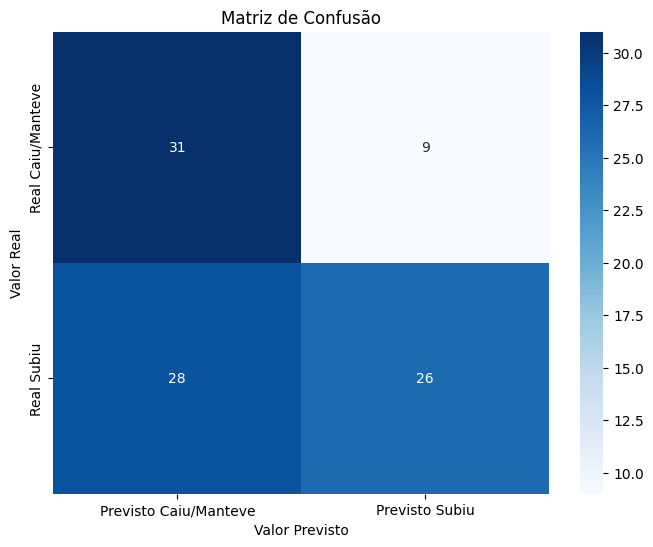

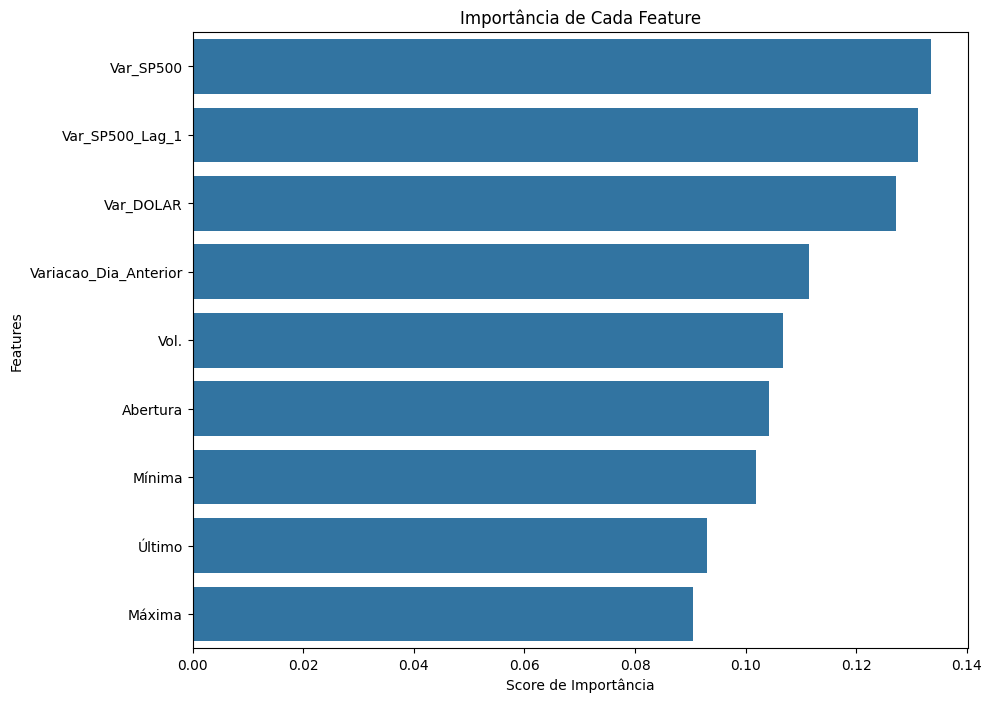

In [120]:
# Avaliação do Desempenho
previsoes = modelo.predict(X_teste)

# Calcular a acurácia
acuracia = accuracy_score(y_teste, previsoes)
print(f"\n--- Resultados da Avaliação ---")
print(f"Acurácia do Modelo: {acuracia:.2%}")

# Exibir o Relatório de Classificação
print("\nRelatório de Classificação:")
# target_names mapeia os valores 0 e 1 para rótulos mais claros
print(classification_report(y_teste, previsoes, target_names=['Caiu/Manteve (0)', 'Subiu (1)']))

# Exibir a Matriz de Confusão
print("\nMatriz de Confusão:")
cm = confusion_matrix(y_teste, previsoes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsto Caiu/Manteve', 'Previsto Subiu'],
            yticklabels=['Real Caiu/Manteve', 'Real Subiu'])
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.title('Matriz de Confusão')
plt.show()

# Importância das Features
# Ver quais features o modelo considerou mais importantes para a decisão
importancias = pd.Series(modelo.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=importancias, y=importancias.index)
plt.title('Importância de Cada Feature')
plt.xlabel('Score de Importância')
plt.ylabel('Features')
plt.show()